In [1]:
using CSV
using DataFrames
using ScikitLearn
using Statistics
using Plots
using ScikitLearn.CrossValidation: train_test_split

@sk_import ensemble: RandomForestClassifier
@sk_import metrics: accuracy_score
@sk_import metrics: (precision_score, recall_score, f1_score)
@sk_import metrics: confusion_matrix




[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment
Could not load conda plugin `conda-libmamba-solver`:

dlopen(/Users/mandarangchekar/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/bindings.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libarchive.13.dylib
  Referenced from: <A1C11063-2162-3BE9-8EB8-234003BCB9E4> /Users/mandarangchekar/.julia/conda/3/aarch64/lib/libmamba.2.0.0.dylib
  Reason: tried: '/Users/mandarangchekar/.julia/conda/3/aarch64/lib/libarchive.13.dylib' (no such file), '/Users/mandarangchekar/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/../../../libarchive.13.dylib' (no such file), '/Users/mandarangchekar/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/../../../libarchive.13.dylib' (no such file), '/Users/mandarangchekar/.julia/conda/3/aarch64/bin/../lib/libarchive.13.dylib'

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0




In [2]:

# Load data
data = CSV.File("71-80.csv") |> DataFrame

# Function to normalize data
function normalize(df::AbstractDataFrame, cols::Vector{<:AbstractString})
    means = mean.(eachcol(df[:, cols]))
    stds = std.(eachcol(df[:, cols]))

    # Convert means and stds to the appropriate shape for broadcasting
    means_matrix = repeat(means', nrow(df), 1)
    stds_matrix = repeat(stds', nrow(df), 1)

    return (df[:, cols] .- means_matrix) ./ stds_matrix
end


normalize (generic function with 1 method)

In [3]:

# Normalize citation data and classify the ratio
data[:, "ratio"] = data[:, "cit_2022"] ./ data[:, "cit_2021"]
data[:, "category"] = ifelse.(data[:, "ratio"] .< 1.05, 1, ifelse.(data[:, "ratio"] .< 1.15, 2, 3))

# Normalize citation data
X_normalized = normalize(data, ["cit_2017", "cit_2018", "cit_2019", "cit_2020", "cit_2021", "cit_2022"])

# Convert the normalized data to a Matrix for the features
X_matrix = Matrix(X_normalized)
y_vector = Vector(data[:, "category"])  # Convert the target variable to a Vector

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_vector, test_size=0.2, random_state=42)

println("Below is X_train:")
println(X_train)
println("_______________________________________________________")
println("Below is Y_train:")
println(y_train)


Below is X_train:
[-0.4554573987855993 -0.4862973757667193 -0.4846783474385188 -0.3796592340735408 -0.45562961148986064 -0.4243100734177345; -0.5841811712654914 -0.6286398875774509 -0.6569945019900284 -0.6619406161964475 -0.6883104003996909 -0.7079275704195408; -0.4534141643017915 -0.49815925175094694 -0.4944690380380364 -0.49958269706693254 -0.45378293856200486 -0.42613986372097196; 0.2964528912556753 0.6306959460813837 0.9584694469303742 0.9874682440511252 1.0013953285883626 0.9425432831006478; -0.43093858497990556 -0.44675778915262715 -0.47097138059919413 -0.4774429808219987 -0.4316228634277353 -0.4060121703853599; -0.5269706057188728 -0.5218830037194022 -0.5551713197550454 -0.508807578835655 -0.5424232390990831 -0.43894839584363415; 1.6245553057307527 1.4867279962764786 1.5713666784601754 1.2273151700379088 1.3430298202416848 1.0797775558434572; 2.0597642507818166 2.4396320336760993 2.8794029425557253 2.935763273605305 2.846221583516303 2.618631200866161; -0.4963220884617556 -0.567

In [4]:
# Create the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
fit!(model, X_train, y_train)


PyObject RandomForestClassifier(random_state=42)

In [5]:

# Predict the categories of the test set
predictions = predict(model, X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
println("Accuracy: $accuracy")

Accuracy: 0.65


In [6]:

# Predict the categories of the test set
y_pred = predict(model, X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

println("Confusion Matrix:")
println(cm)


Confusion Matrix:
[8 2 0; 1 0 1; 3 0 5]


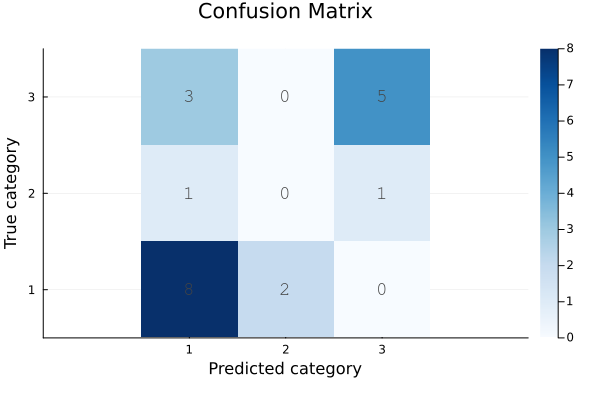

GKS: could not find font middle.ttf


In [7]:
# Compute unique categories for labeling
categories = sort(unique(y_test))
num_categories = length(categories)

# Create the heatmap plot
plt = heatmap(1:num_categories, 1:num_categories, cm,
              color=:Blues,
              xlabel="Predicted category",
              ylabel="True category",
              title="Confusion Matrix",
              xticks=(1:num_categories, categories),
              yticks=(1:num_categories, categories),
              aspect_ratio=:equal)

# Annotate with the actual count numbers
for (i, actual_category) in enumerate(categories)
    for (j, predicted_category) in enumerate(categories)
        annotate!(plt, j, i, text(string(cm[i, j]), :center, :middle, 10))
    end
end

plt

In [8]:

precision = precision_score(y_test, predictions; average="weighted")
recall = recall_score(y_test, predictions; average="weighted")
f1 = f1_score(y_test, predictions; average="weighted")

println("Precision: $precision")
println("Recall: $recall")
println("F1 Score: $f1")

Precision: 0.6666666666666666
Recall: 0.65
F1 Score: 0.6493506493506492
